In [195]:
import torch
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

In [196]:
path = os.getcwd()+'\Joint_Dataset.csv'

In [197]:
dataset = pd.read_csv(path)
dataset_shuffle = shuffle(dataset)

In [198]:
X = dataset_shuffle.drop('label',axis=1)
y = dataset_shuffle['label']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [200]:
trainset = pd.concat([X_train,y_train],axis=1)
testset = pd.concat([X_test,y_test],axis=1)

In [201]:
class MSRDataset(Dataset):
    def __init__(self,data):
        self.len = data.shape[0]
        self.x_data = torch.from_numpy(data.drop('label',axis=1).to_numpy()).float()
        self.y_data = torch.from_numpy(data['label'].to_numpy()-1).type(torch.LongTensor)
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len

In [202]:
train_data = MSRDataset(trainset)
test_data = MSRDataset(testset)

In [203]:
trainloader = DataLoader(dataset=train_data,batch_size=64,shuffle=True,num_workers=0)
testloader = DataLoader(dataset=test_data,batch_size=64,shuffle=True,num_workers=0)

In [204]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(60, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40,40)
        self.fc5 = nn.Linear(40,20)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x,dim=1)

In [205]:
model = Net()

In [206]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [207]:
N_s = trainset.shape[0] #Nₛ the number of samples in the training data
# batch_size, epoch and iteration
batch_size = 64
n_iters = 8000
num_epochs = n_iters / (N_s / batch_size)
num_epochs = int(num_epochs)
num_epochs

33

In [208]:
loss_list = []
ite_list = []
accuracy_list = []
count=0
for epoch in range(num_epochs):
    for i,data in enumerate(trainloader):
        inputs,labels = data
        inputs,labels = Variable(inputs),Variable(labels)
        #pdb.set_trace()
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        count+=1
        #print("iteration",count)
        if count %250 == 0:
            correct = 0
            total = 0
            loss_list.append(loss.data)
            ite_list.append(count)
            with torch.no_grad():
                for data in testloader:
                    inputs,labels = data
                    inputs,labels = Variable(inputs),Variable(labels)
                    output = model(inputs)
                    for idx, i in enumerate(output):
                        #pdb.set_trace()
                        if torch.argmax(i) == labels[idx]:
                            correct+=1
                        total+=1
            accuracy_list.append(round(correct/total,3)*100)
            if count % 500 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, round(correct/total,3)*100))
        

Iteration: 500  Loss: 2.4827771186828613  Accuracy: 20.8 %
Iteration: 1000  Loss: 2.506694793701172  Accuracy: 24.099999999999998 %
Iteration: 1500  Loss: 2.426290512084961  Accuracy: 26.6 %
Iteration: 2000  Loss: 2.0924935340881348  Accuracy: 28.1 %
Iteration: 2500  Loss: 1.8676948547363281  Accuracy: 30.2 %
Iteration: 3000  Loss: 2.1429617404937744  Accuracy: 31.8 %
Iteration: 3500  Loss: 2.0744757652282715  Accuracy: 33.2 %
Iteration: 4000  Loss: 1.7783362865447998  Accuracy: 34.1 %
Iteration: 4500  Loss: 2.4842045307159424  Accuracy: 28.1 %
Iteration: 5000  Loss: 1.8206332921981812  Accuracy: 35.6 %
Iteration: 5500  Loss: 2.1097116470336914  Accuracy: 35.9 %
Iteration: 6000  Loss: 1.9558539390563965  Accuracy: 36.7 %
Iteration: 6500  Loss: 1.815490961074829  Accuracy: 38.6 %
Iteration: 7000  Loss: 1.7951037883758545  Accuracy: 37.9 %
Iteration: 7500  Loss: 1.756082534790039  Accuracy: 38.6 %


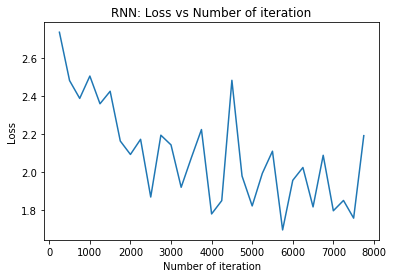

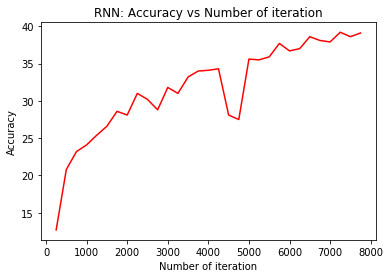

In [209]:
# visualization loss 
plt.plot(ite_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(ite_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
#plt.savefig('graph.png')
plt.show()